<a href="https://colab.research.google.com/github/robin-ochieng/time-series/blob/main/Renewals_XGBoost_Vehicle_sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

## Data preprocessing


In [2]:
#import/load the data 
sales_data = pd.read_excel('renewal_sales.xlsx',  index_col='Date', parse_dates = True)

In [3]:
sales_data.dtypes

Name              object
Type of Cover     object
Plate Number      object
Sales            float64
dtype: object

In [4]:
sales_data

,Name,Type of Cover,Plate Number,Sales
Date,,,,
2022-01-02,ELIZABETH GONDI,COMPREHENSIVE,KAQ 910F,42153.0
2022-01-05,ALICE WANJIRU MUCHIRA,TPO,KCH 795C,2050.0
2022-01-05,MEULEDI K. MABRUKI ISEME,COMPREHENSIVE,KBY 037V,38714.0
2022-01-05,ROSELYNE ADONGO NGURE,TPO,KBE 129G,7574.0
2022-01-05,SAMUEL MWANGI MBICHO,TPO,KDA 995H,5063.0
...,...,...,...,...
2022-12-31,LUCAS NGONGA,COMPREHENSIVE,KCG786F,82337.5
2022-12-31,ANDREW MUTUMA/ ELIZABETH GAKI,COMPREHENSIVE,NaN,274731.0
2022-12-31,CHARLES ORINA MAKORI,THIRD PARTY ONLY,KBG196A,5063.0


In [5]:
new_business_sales = sales_data.iloc[:, 3:]

In [6]:
new_business_sales

,Sales
Date,
2022-01-02,42153.0
2022-01-05,2050.0
2022-01-05,38714.0
2022-01-05,7574.0
2022-01-05,5063.0
...,...
2022-12-31,82337.5
2022-12-31,274731.0
2022-12-31,5063.0


In [7]:
new_business_sales = new_business_sales.resample('D').sum()

In [8]:
new_business_sales

,Sales
Date,
2022-01-02,42153.00
2022-01-03,0.00
2022-01-04,0.00
2022-01-05,53401.00
2022-01-06,0.00
...,...
2022-12-27,7574.00
2022-12-28,0.00
2022-12-29,41727.00


In [9]:
vehicle_sales =  new_business_sales[new_business_sales != 0]
print(vehicle_sales)

                Sales
Date                 
2022-01-02   42153.00
2022-01-03        NaN
2022-01-04        NaN
2022-01-05   53401.00
2022-01-06        NaN
...               ...
2022-12-27    7574.00
2022-12-28        NaN
2022-12-29   41727.00
2022-12-30  184948.75
2022-12-31  372257.50

[364 rows x 1 columns]


In [10]:
vehicle_sales = vehicle_sales.dropna(subset=['Sales'])
print(vehicle_sales)

                Sales
Date                 
2022-01-02   42153.00
2022-01-05   53401.00
2022-01-07   64785.00
2022-01-08    7574.00
2022-01-10   83162.00
...               ...
2022-12-23  121986.25
2022-12-27    7574.00
2022-12-29   41727.00
2022-12-30  184948.75
2022-12-31  372257.50

[275 rows x 1 columns]


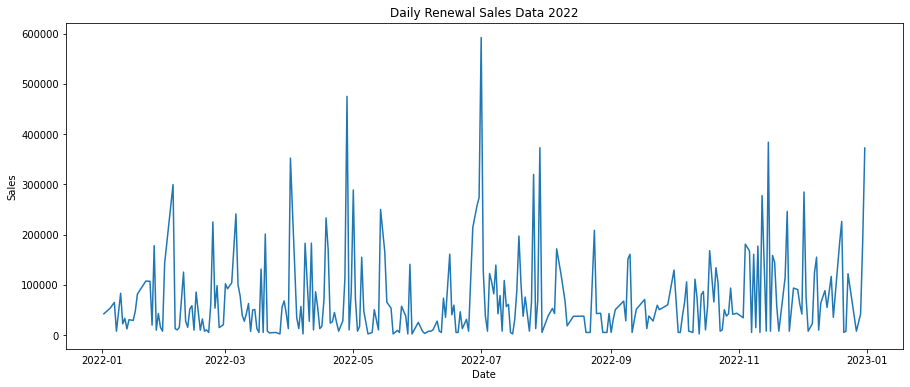

In [11]:
# Plot the sales data to visualize the trend and seasonality
plt.figure(figsize=(15,6))
plt.plot(vehicle_sales['Sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Renewal Sales Data 2022')
plt.show()

In [12]:
vehicle_sales

,Sales
Date,
2022-01-02,42153.00
2022-01-05,53401.00
2022-01-07,64785.00
2022-01-08,7574.00
2022-01-10,83162.00
...,...
2022-12-23,121986.25
2022-12-27,7574.00
2022-12-29,41727.00


In [13]:
# Adding time-based features to the data
vehicle_sales['year'] = vehicle_sales.index.year
vehicle_sales['month'] = vehicle_sales.index.month
vehicle_sales['day'] = vehicle_sales.index.day
vehicle_sales['weekday'] = vehicle_sales.index.weekday
vehicle_sales['week'] = vehicle_sales.index.week
vehicle_sales['quarter'] = vehicle_sales.index.quarter

<ipython-input-13-879cd9243c6b>:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  vehicle_sales['week'] = vehicle_sales.index.week


In [14]:
vehicle_sales

,Sales,year,month,day,weekday,week,quarter
Date,,,,,,,
2022-01-02,42153.00,2022,1,2,6,52,1
2022-01-05,53401.00,2022,1,5,2,1,1
2022-01-07,64785.00,2022,1,7,4,1,1
2022-01-08,7574.00,2022,1,8,5,1,1
2022-01-10,83162.00,2022,1,10,0,2,1
...,...,...,...,...,...,...,...
2022-12-23,121986.25,2022,12,23,4,51,4
2022-12-27,7574.00,2022,12,27,1,52,4
2022-12-29,41727.00,2022,12,29,3,52,4


## Feature Engineering


In [15]:
# Creating lag features
for i in range(1, 32):
    vehicle_sales[f'sales_lag_{i}'] = vehicle_sales['Sales'].shift(i)

In [16]:
# Removing rows with missing values
vehicle_sales.dropna(inplace=True)

In [17]:
vehicle_sales

,Sales,year,month,day,weekday,week,quarter,sales_lag_1,sales_lag_2,sales_lag_3,...,sales_lag_22,sales_lag_23,sales_lag_24,sales_lag_25,sales_lag_26,sales_lag_27,sales_lag_28,sales_lag_29,sales_lag_30,sales_lag_31
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-15,85423.00,2022,2,15,1,7,1,9637.00,58395.00,51812.00,...,28919.0,30411.0,12050.0,33230.00,22140.00,83162.00,7574.00,64785.00,53401.0,42153.00
2022-02-17,9637.00,2022,2,17,3,7,1,85423.00,9637.00,58395.00,...,47754.0,28919.0,30411.0,12050.00,33230.00,22140.00,83162.00,7574.00,64785.0,53401.00
2022-02-18,31952.00,2022,2,18,4,7,1,9637.00,85423.00,9637.00,...,81445.0,47754.0,28919.0,30411.00,12050.00,33230.00,22140.00,83162.00,7574.0,64785.00
2022-02-19,7574.00,2022,2,19,5,7,1,31952.00,9637.00,85423.00,...,107350.0,81445.0,47754.0,28919.00,30411.00,12050.00,33230.00,22140.00,83162.0,7574.00
2022-02-20,10126.00,2022,2,20,6,7,1,7574.00,31952.00,9637.00,...,106933.0,107350.0,81445.0,47754.00,28919.00,30411.00,12050.00,33230.00,22140.0,83162.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,121986.25,2022,12,23,4,51,4,7533.75,5022.50,226122.75,...,7547.0,246182.5,114672.5,42691.25,7574.00,57297.00,144688.50,158369.00,7574.0,383945.61
2022-12-27,7574.00,2022,12,27,1,52,4,121986.25,7533.75,5022.50,...,93418.5,7547.0,246182.5,114672.50,42691.25,7574.00,57297.00,144688.50,158369.0,7574.00
2022-12-29,41727.00,2022,12,29,3,52,4,7574.00,121986.25,7533.75,...,90445.0,93418.5,7547.0,246182.50,114672.50,42691.25,7574.00,57297.00,144688.5,158369.00


In [18]:
# Specifying the features and target variable
X = vehicle_sales.drop('Sales', axis=1)
y = vehicle_sales['Sales']

In [19]:
# Splitting the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Training the Model

In [20]:
# Creating the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=0)

# Fitting the model to the training data
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculating the root mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root mean squared error:', rmse)

Root mean squared error: 111250.79140704314


## Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.
This plot can help you identify which input variables are the most important in predicting the target variable.
We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

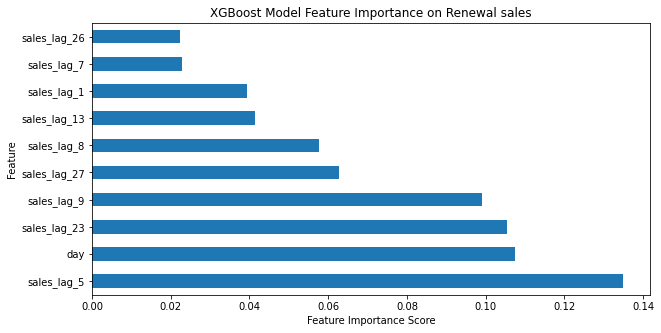

In [21]:
plt.figure(figsize=(10, 5))
feat_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('XGBoost Model Feature Importance on Renewal sales')
plt.show()

#### This Plot the shows the actual vs. predicted sales: This plots the actual and predicted sales data to visually compare the performance of the model.

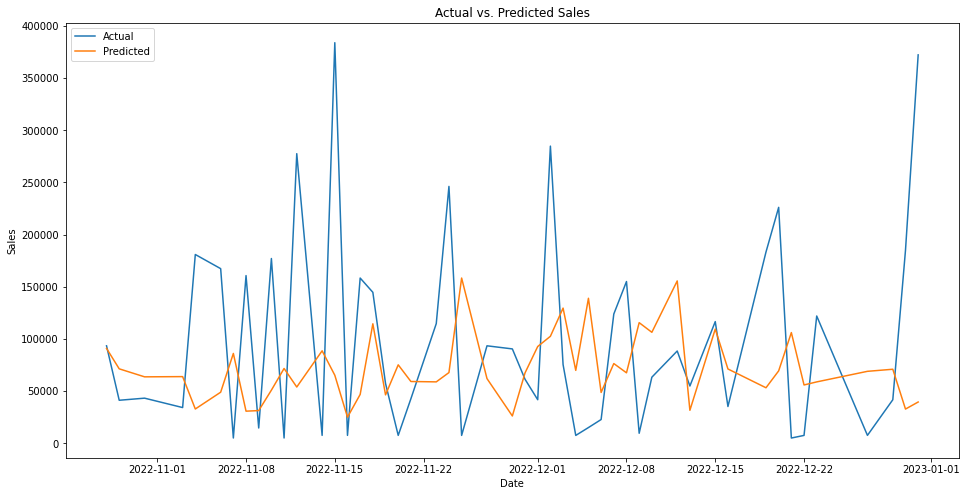

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs. Predicted Sales')
plt.legend()
plt.show()


In [23]:
df_pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
df_pred

,y_test,y_pred
Date,,
2022-10-28,93418.500,90921.007812
2022-10-29,41225.000,71348.414062
2022-10-31,43234.000,63674.386719
2022-11-03,34233.250,63885.433594
2022-11-04,180930.000,32862.496094
2022-11-06,167370.000,48950.781250
2022-11-07,5063.000,86092.273438
2022-11-08,160709.700,30772.289062
2022-11-09,14648.000,31324.050781


In [24]:
#Creating a DataFrame with the time-based features for the future dates
future_dates = pd.date_range(start='2023-01-01', end='2023-03-31', freq='D')

In [25]:
#Creating a DataFrame with the time-based features for the future dates:
future_data = pd.DataFrame({
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day,
    'weekday': future_dates.weekday,
    'week': future_dates.week,
    'quarter': future_dates.quarter
})

<ipython-input-25-7bf4e5296222>:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  'week': future_dates.week,


In [26]:
#Add lag features to the future data using the last 31 days of sales from the original data
for i in range(1, 32):
    future_data[f'sales_lag_{i}'] = vehicle_sales['Sales'].shift(i).values[-90:]


In [27]:
#Use the trained XGBoost model to make predictions on the future data
future_predictions = xgb_model.predict(future_data)

In [28]:
#Create a DataFrame with the date and predicted sales for the next three months:
forecast = pd.DataFrame({
    'Date': future_dates,
    'Sales': future_predictions
})

In [29]:
forecast

,Date,Sales
0,2023-01-01,102311.578125
1,2023-01-02,67231.875000
2,2023-01-03,32974.679688
3,2023-01-04,52878.359375
4,2023-01-05,70550.578125
...,...,...
85,2023-03-27,82167.281250
86,2023-03-28,69273.109375
87,2023-03-29,69862.289062
88,2023-03-30,30810.056641


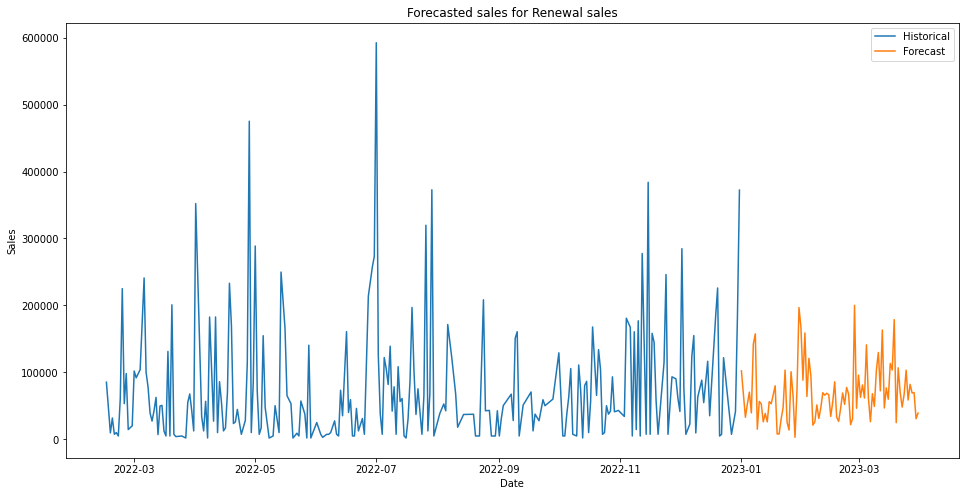

In [30]:
#Visualize the forecasted sales:
plt.figure(figsize=(16, 8))
plt.plot(vehicle_sales.index, vehicle_sales['Sales'], label='Historical')
plt.plot(forecast['Date'], forecast['Sales'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Forecasted sales for Renewal sales')
plt.legend()
plt.show()